In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import math
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/datasets_itmo/bioresponse.csv', header=0, sep=',')

In [5]:
df_log_reg = df.drop(['Activity'], axis=1)
scaler = StandardScaler()
X=scaler.fit_transform(df_log_reg)
y=df['Activity'].values

In [6]:
y = df.Activity.values
X = df.iloc[:, 1:]

In [7]:
X_train, y_train, X_test, y_test = train_test_split(X, y,test_size = 0.25, random_state = 1)

In [8]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2813, 1776) (938, 1776)
(2813,) (938,)


In [9]:
# sigmoid
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1./(1.+np.exp(-z))
    return s

In [10]:
# initialize_with_zeros
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.

    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)

    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    w = np.zeros((dim,1), dtype=float)
    b = 0.
    return w, b

In [11]:
# propagate

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size which equals the number of features
    b -- bias, a scalar
    X -- data
    Y -- true "label" vector (containing 0 and 1) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b

    """

    m = X.shape[1]
    #print('number of objects = ',len(X))

    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T,X)+b)                                  # compute activation
    cost = -(1./m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A),axis=1)   # compute cost

    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (1./m)*np.dot(X,(A-Y).T)
    db = (1./m)*np.sum(A-Y,axis=1)

    grads = {"dw": dw,
             "db": db}

    return grads, cost

In [12]:
# optimize
def GD(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm

    Arguments:
    w -- weights, a numpy array
    b -- bias, a scalar
    X -- data
    Y -- true "label" vector (containing 0 and 1), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps

    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    """

    costs = []

    for i in range(num_iterations):

        # Cost and gradient calculation
        grads, cost = propagate(w,b,X,Y)

        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]

        # update rule
        w -=learning_rate*dw
        b -=learning_rate*db

        costs.append(cost)
        # Record the costs
        #if i % 100 == 0:
            #costs.append(cost)

        # Print the cost every 100 training iterations
        #if print_cost and i % 100 == 0:
            #print ("Cost after iteration %i: %f" %(i, cost))

    params = {"w": w,
              "b": b}

    grads = {"dw": dw,
             "db": db}
    return params, grads, costs

In [13]:
# predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)

    Arguments:
    w -- weights, a numpy array
    b -- bias, a scalar
    X -- data

    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''

    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)

    # Compute vector "A" predicting the probabilities
    A = sigmoid(np.dot(w.T,X)+b)

    for i in range(A.shape[1]):

        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if (A[0,i]<=0.5):
            Y_prediction[0][i]=0
        else:
            Y_prediction[0][i]=1

    return Y_prediction

In [14]:
# model

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False, optimizer='GD'):
    """
    Builds the logistic regression model by calling the function we've implemented previously

    Arguments:
    X_train -- training set represented by a numpy array
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations

    Returns:
    d -- dictionary containing information about the model.
    """

    # initialize parameters with zeros
    w, b = initialize_with_zeros(X_train.shape[0])

    if optimizer == 'GD':
      parameters, grads, costs = GD(w, b, X_train, Y_train, num_iterations, learning_rate)
    elif optimizer == 'adam':
      parameters, grads, costs = adam(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    elif optimizer == 'SGD':
      parameters, grads, costs = SGD(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    else:
      return("ERROR")

    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]

    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train" : Y_prediction_train,
         "w" : w,
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    print(costs)
    return d

In [15]:
def SGD(w, b, X, Y, num_iterations, learning_rate, print_cost = False, batch_size=256):
    costs = []

    for i in range(num_iterations):
        random_batch_x = np.random.choice(X.shape[1], batch_size, replace=False)
        random_batch_y = np.random.choice(Y.shape[0], batch_size, replace=False)

        X = np.take(X, random_batch_x, axis=1)
        Y = np.take(Y, random_batch_x, axis=0)

        grads, cost = propagate(w,b,X,Y)

        dw = grads["dw"]
        db = grads["db"]

        w -=learning_rate*dw
        b -=learning_rate*db

        # Record the costs
        if i % 100 == 0:
            costs.append(cost)

        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))


    params = {"w": w,
              "b": b}

    grads = {"dw": dw,
             "db": db}

    return params, grads, costs

In [16]:
def adam(w, b, X, Y, num_iterations, learning_rate, print_cost = False, b1=0.9, b2=0.999):

    costs = []
    sw, sb = 0, 0
    rw, rb = 0, 0
    num_stubilizer: float = 1e-8 # constant for numerical stabilization

    for i in range(num_iterations):
        # Cost and gradient calculation
        grads, cost = propagate(w,b,X,Y)
        if math.isnan(cost):
            break
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]

        sw = b1*sw + (1. - b1) * dw
        rw = b2*rw + (1. - b2) * dw**2
        cor_sw = sw / (1. - b1**(i+1))
        cor_rw = rw / (1. - b2**(i+1))

        sb = b1*sb + (1. - b1) * db
        rb = b2*rb + (1. - b2) * db**2
        cor_sb = sb / (1. - b1**(i+1))
        cor_rb = rb / (1. - b2**(i+1))

        # update rule
        w -= learning_rate * cor_sw / (np.sqrt(cor_rw) + num_stubilizer)
        b -= learning_rate * cor_sb / (np.sqrt(cor_rb) + num_stubilizer)

        # Record the costs
        if i % 100 == 0:
            costs.append(cost)

        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    params = {"w": w,
              "b": b}

    grads = {"dw": dw,
             "db": db}

    return params, grads, costs

train accuracy: 68.9655172413793 %
test accuracy: 71.1087420042644 %
[array([0.69314718]), array([0.69302654]), array([0.69290713]), array([0.69278893]), array([0.69267191]), array([0.69255607]), array([0.69244139]), array([0.69232784]), array([0.69221542]), array([0.6921041]), array([0.69199388]), array([0.69188473]), array([0.69177664]), array([0.6916696]), array([0.69156358]), array([0.69145859]), array([0.69135459]), array([0.69125158]), array([0.69114955]), array([0.69104847]), array([0.69094833]), array([0.69084913]), array([0.69075085]), array([0.69065347]), array([0.69055699]), array([0.69046138]), array([0.69036664]), array([0.69027276]), array([0.69017972]), array([0.69008751]), array([0.68999612]), array([0.68990553]), array([0.68981574]), array([0.68972673]), array([0.6896385]), array([0.68955103]), array([0.68946431]), array([0.68937833]), array([0.68929308]), array([0.68920855]), array([0.68912473]), array([0.68904161]), array([0.68895918]), array([0.68887742]), array([0.

Text(0, 0.5, 'loss')

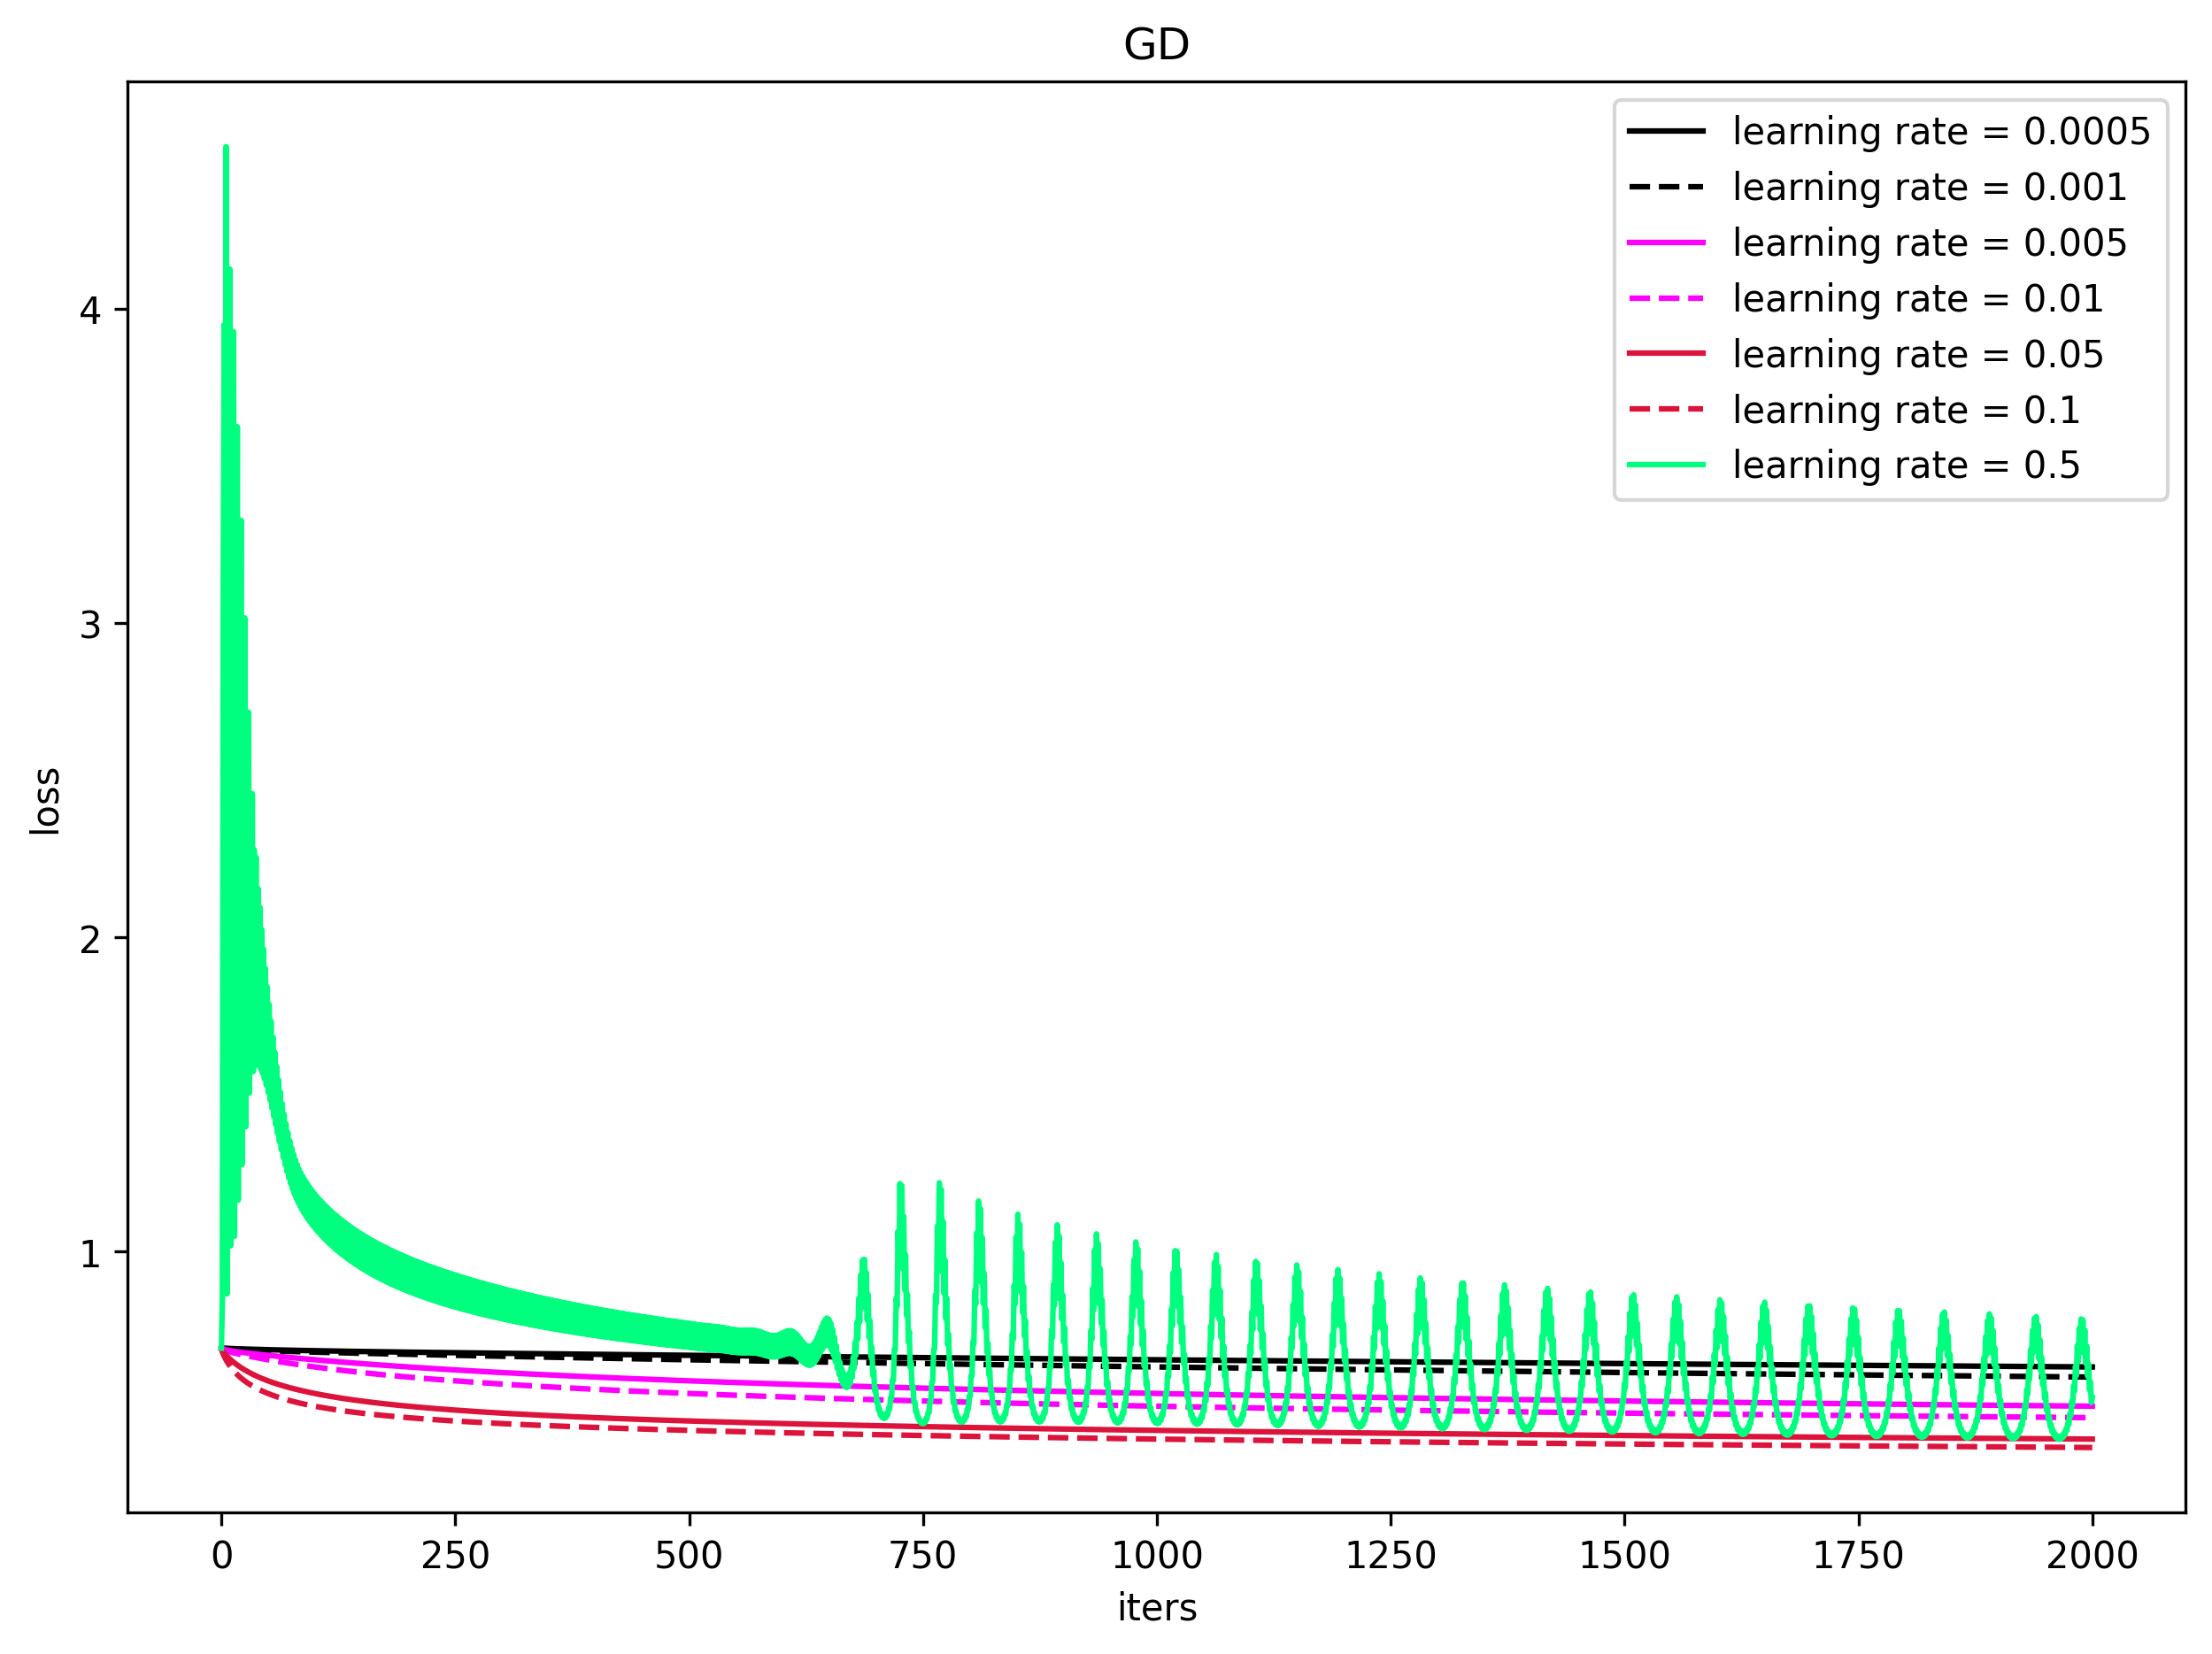

In [37]:
fig, axis = plt.subplots(figsize=(10,7), dpi=300)
iters = np.linspace(0, 2000,2000)

rate = [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
ln_stl = ['-', '--', '-', '--', '-', '--', '-']
color = ['black', 'black', 'magenta', 'magenta', 'crimson', 'crimson', 'springgreen']
for i in range(len(rate)):
  d = model(X_train.T, X_test.T, y_train.T, y_test.T, num_iterations = 2000, optimizer='GD', learning_rate = rate[i], print_cost = True)
  axis.plot(iters, d['costs'], label='learning rate = '+str(rate[i]), linestyle=ln_stl[i], color=color[i])

axis.set_title("GD")
axis.legend()
plt.xlabel("iters")
plt.ylabel("loss")

train accuracy: 66.37042303590474 %
test accuracy: 65.99147121535181 %
[array([0.69314718]), array([0.68310104]), array([0.67547946]), array([0.66863299]), array([0.66215339]), array([0.65593062]), array([0.64992749]), array([0.64412538]), array([0.63851105]), array([0.63307333]), array([0.62780226]), array([0.62268874]), array([0.61772442]), array([0.61290162]), array([0.60821323]), array([0.60365269]), array([0.59921387]), array([0.5948911]), array([0.59067907]), array([0.58657284])]
train accuracy: 68.14788482047636 %
test accuracy: 68.12366737739872 %
[array([0.69314718]), array([0.67811902]), array([0.6660187]), array([0.65495419]), array([0.64466991]), array([0.63504447]), array([0.62598956]), array([0.61743643]), array([0.60933008]), array([0.60162548]), array([0.59428504]), array([0.58727682]), array([0.58057332]), array([0.57415054]), array([0.56798737]), array([0.56206503]), array([0.55636678]), array([0.55087754]), array([0.54558372]), array([0.540473])]
train accuracy: 71.5

Text(0, 0.5, 'loss')

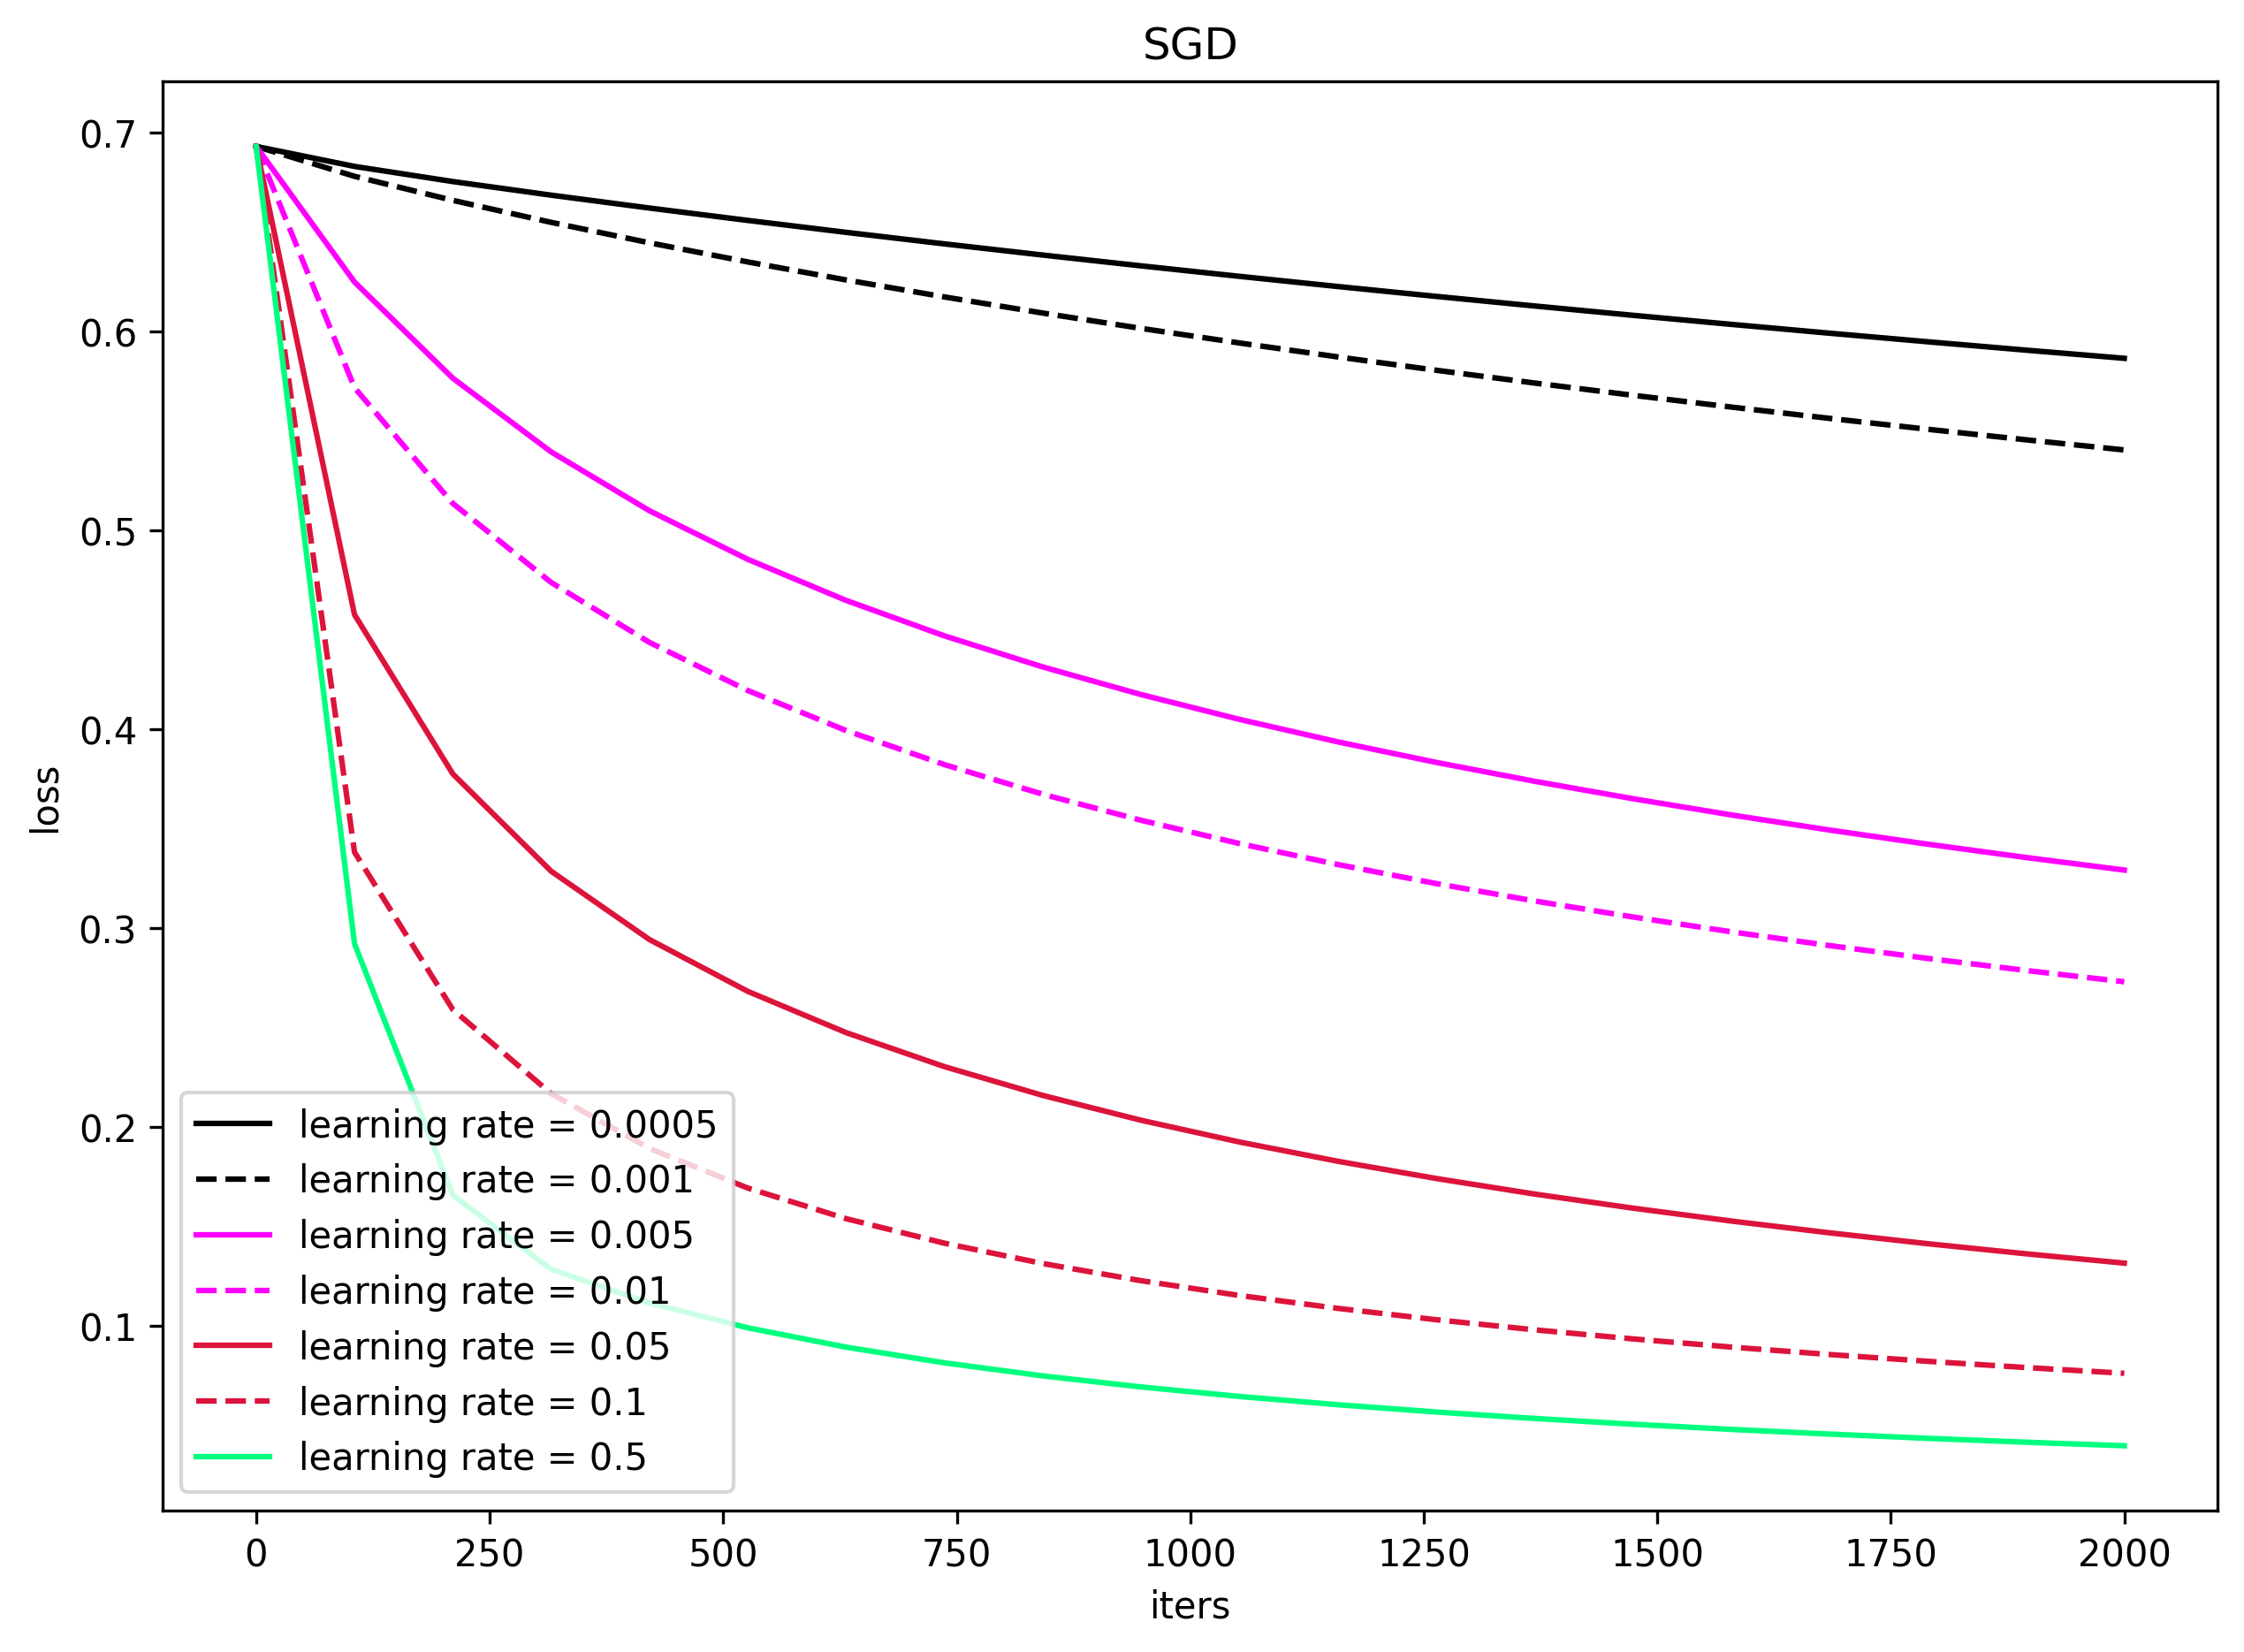

In [60]:
fig, axis = plt.subplots(figsize=(10,7), dpi=300)
iters = np.linspace(0, 2000,20)

rate = [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
ln_stl = ['-', '--', '-', '--', '-', '--', '-']
color = ['black', 'black', 'magenta', 'magenta', 'crimson', 'crimson', 'springgreen']
for i in range(len(rate)):
  d = model(X_train.T, X_test.T, y_train.T, y_test.T, num_iterations = 2000, optimizer='SGD', learning_rate = rate[i], print_cost = False)
  axis.plot(iters, d['costs'], label='learning rate = '+str(rate[i]), linestyle=ln_stl[i], color=color[i])

axis.set_title("SGD")
axis.legend()
plt.xlabel("iters")
plt.ylabel("loss")

train accuracy: 88.62424457874155 %
test accuracy: 74.84008528784648 %
[array([0.69314718]), array([0.55564402]), array([0.49839084]), array([0.46321411]), array([0.43829461]), array([0.41910662]), array([0.40352877]), array([0.39042819]), array([0.3791361]), array([0.36922528]), array([0.36040532]), array([0.35246881]), array([0.34526175]), array([0.33866622]), array([0.33258966]), array([0.32695802]), array([0.32171108]), array([0.31679926]), array([0.31218134]), array([0.30782276])]
train accuracy: 90.47280483469605 %
test accuracy: 74.09381663113007 %
[array([0.69314718]), array([0.50065896]), array([0.44141198]), array([0.40728072]), array([0.3834267]), array([0.3651766]), array([0.3504786]), array([0.33823461]), array([0.32777865]), array([0.3186734]), array([0.3106166]), array([0.30339207]), array([0.29684132]), array([0.29084577]), array([0.28531503]), array([0.28017892]), array([0.27538201]), array([0.27087973]), array([0.2666357]), array([0.26261974])]


<ipython-input-11-f0a9ca94c0d2>:25: RuntimeWarning: divide by zero encountered in log
  cost = -(1./m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A),axis=1)   # compute cost
<ipython-input-11-f0a9ca94c0d2>:25: RuntimeWarning: invalid value encountered in multiply
  cost = -(1./m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A),axis=1)   # compute cost


train accuracy: 93.38784216139354 %
test accuracy: 74.20042643923242 %
[array([0.69314718]), array([0.39803372]), array([0.34516217]), array([0.31520068]), array([0.29450555]), array([0.2787921]), array([0.26614782]), array([0.25556979]), array([0.24646988]), array([0.23847468]), array([0.23133321]), array([0.22486963]), array([0.21895668]), array([0.21349975]), array([0.20842679]), array([0.20368173]), array([0.19922009]), array([0.19500603]), array([0.19101017])]
train accuracy: 93.10344827586206 %
test accuracy: 73.98720682302772 %
[array([0.69314718]), array([0.3797231]), array([0.32960193]), array([0.30061253]), array([0.28040642]), array([0.26496061]), array([0.25246169]), array([0.24195669]), array([0.23288644]), array([0.224896]), array([0.21774645]), array([0.21126952]), array([0.20534223]), array([0.19987209])]
train accuracy: 92.78350515463917 %
test accuracy: 74.20042643923242 %
[array([0.69314718]), array([0.33365934]), array([0.28717189]), array([0.25995921]), array([0.24

Text(0, 0.5, 'loss')

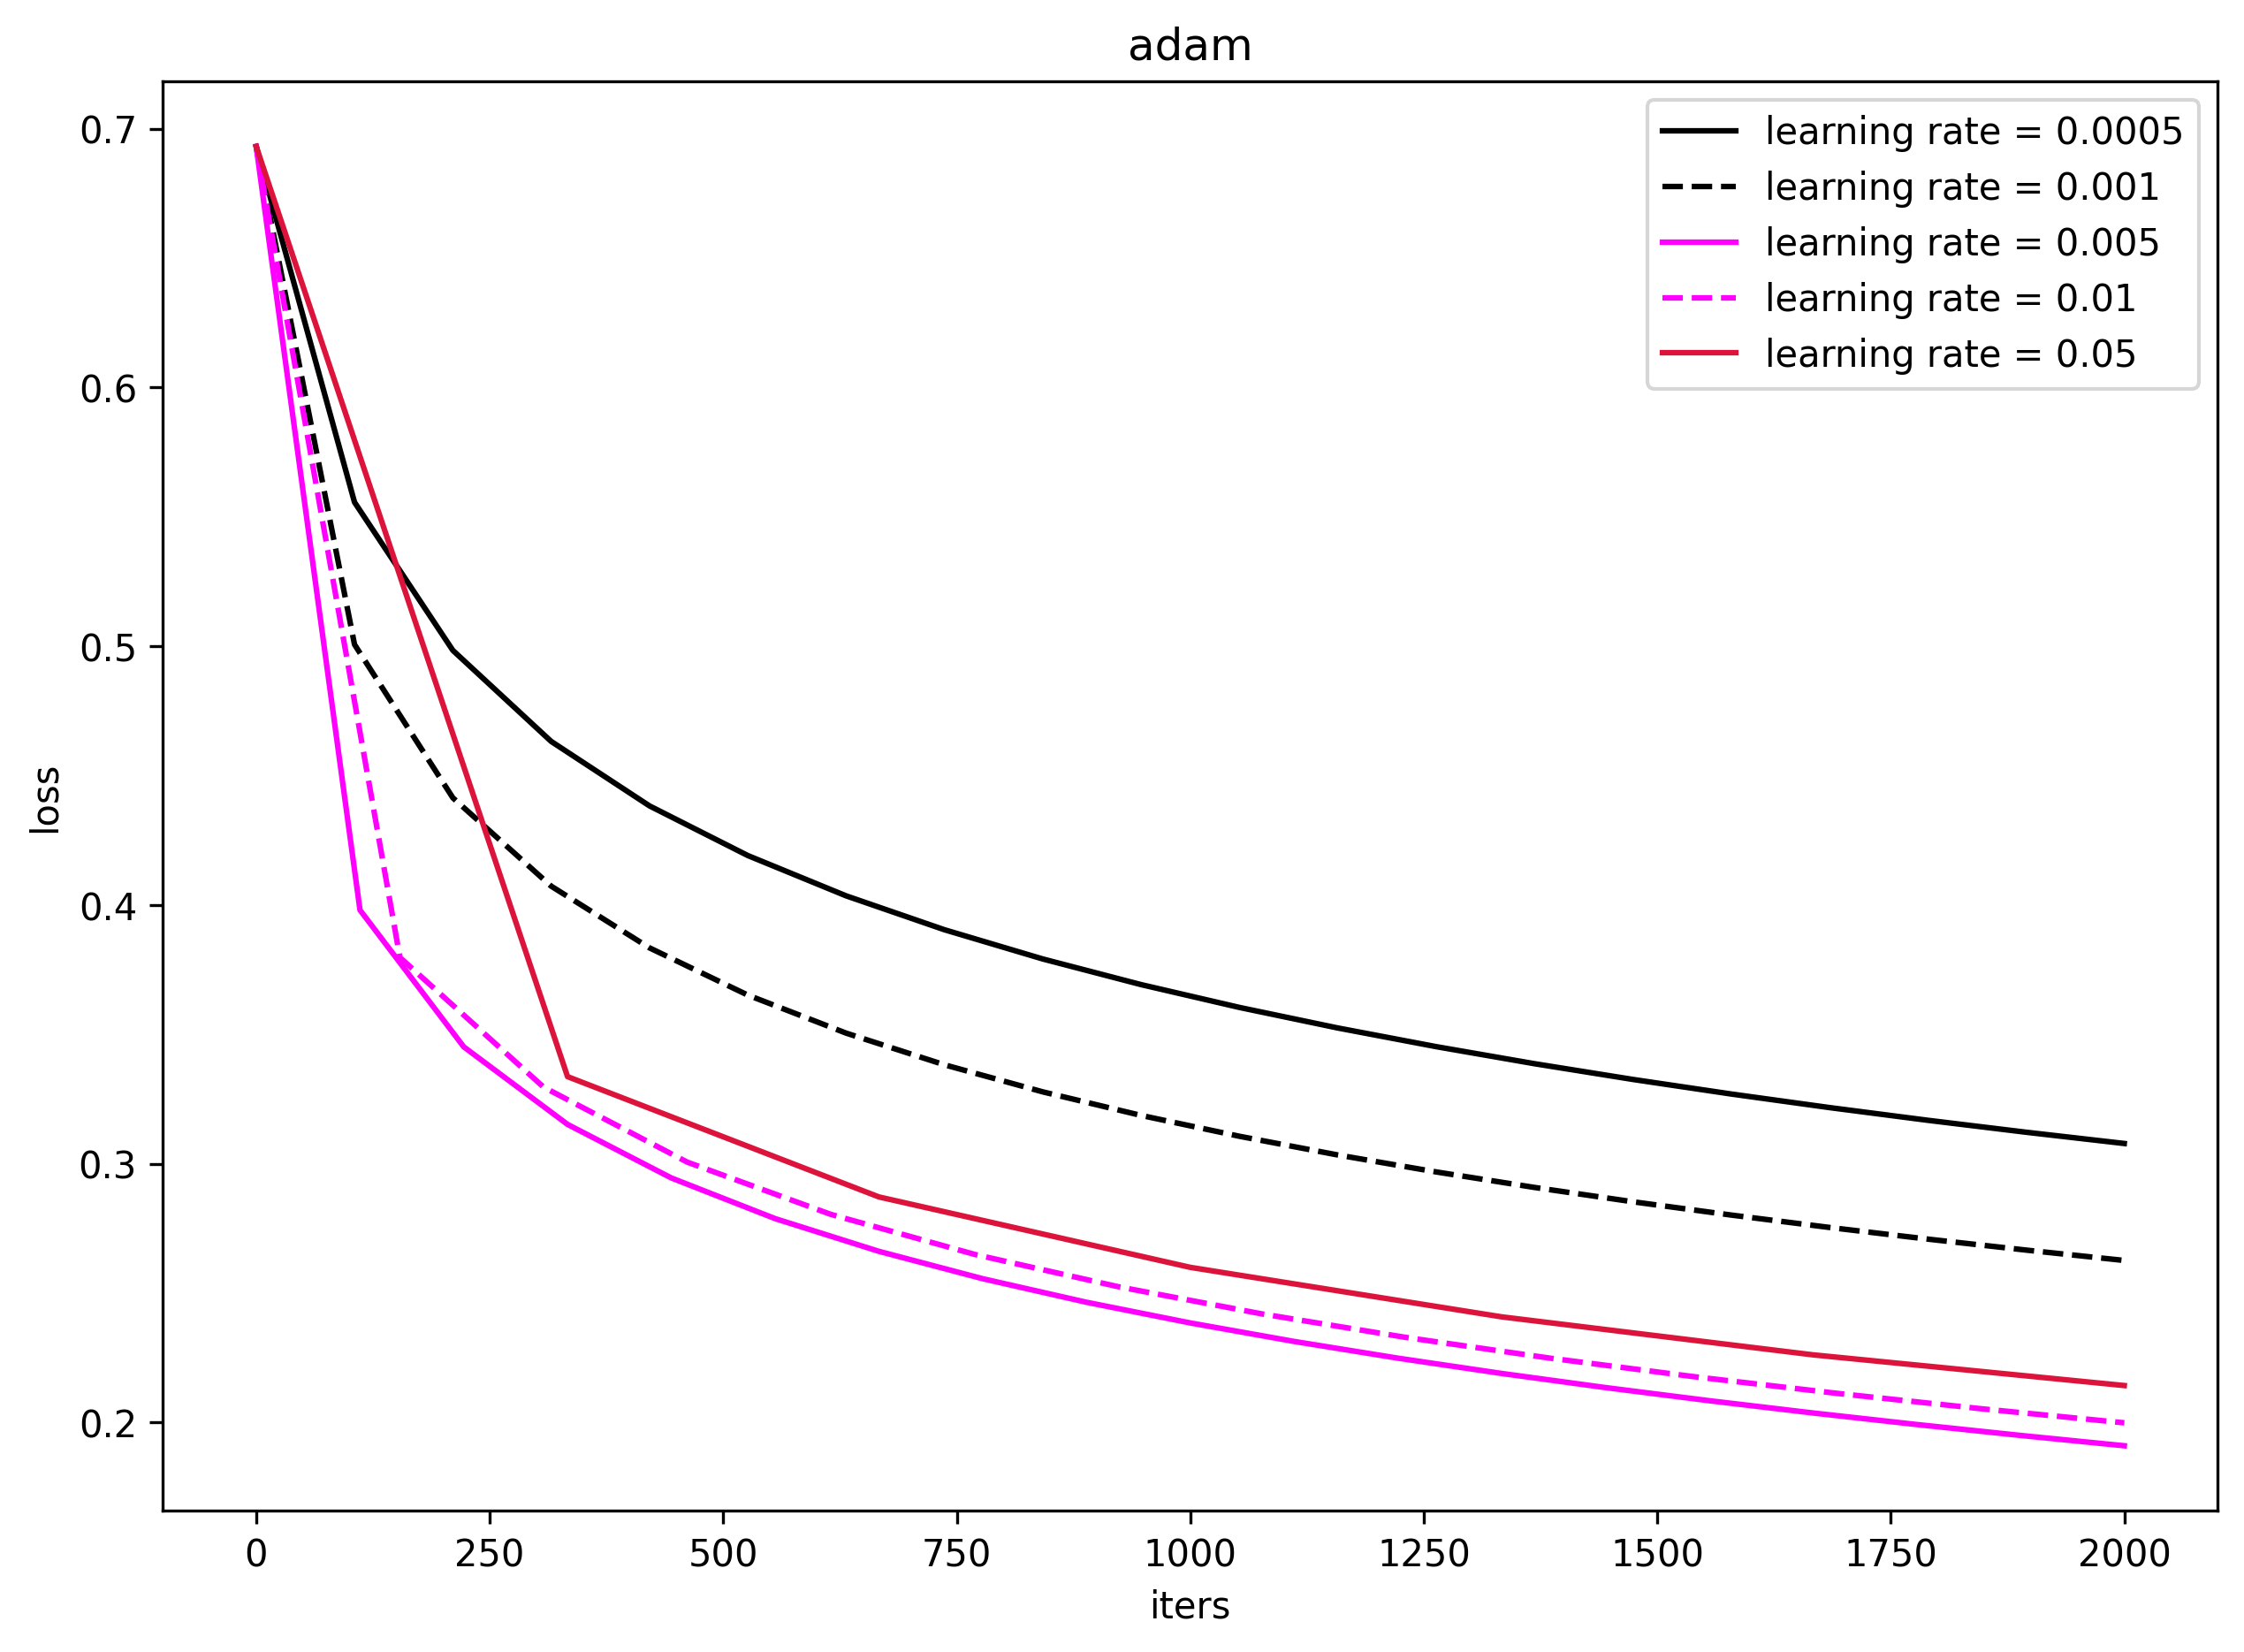

In [59]:
fig, ax = plt.subplots(figsize=(10,7), dpi=300)
iters = np.linspace(0, 2000,20)

rate = [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
ln_stl = ['-', '--', '-', '--', '-', '--', '-']
color = ['black', 'black', 'magenta', 'magenta', 'crimson', 'crimson', 'springgreen']
#for i in range(len(rate)):
  #d = model(X_train.T, X_test.T, y_train.T, y_test.T, num_iterations = 2000, optimizer='adam', learning_rate = rate[i], print_cost = False)
  #axis.plot(iters, d['costs'], label='learning rate = '+str(rate[i]), linestyle=ln_stl[i], color=color[i])

d = model(X_train.T, X_test.T, y_train.T, y_test.T, num_iterations = 2000, optimizer='adam', learning_rate = rate[0], print_cost = False)
ax.plot(iters, d['costs'], label='learning rate = '+str(rate[0]), linestyle=ln_stl[0], color=color[0])

d = model(X_train.T, X_test.T, y_train.T, y_test.T, num_iterations = 2000, optimizer='adam', learning_rate = rate[1], print_cost = False)
ax.plot(iters, d['costs'], label='learning rate = '+str(rate[1]), linestyle=ln_stl[1], color=color[1])

iters = np.linspace(0, 2000,19)
d = model(X_train.T, X_test.T, y_train.T, y_test.T, num_iterations = 2000, optimizer='adam', learning_rate = rate[2], print_cost = False)
ax.plot(iters, d['costs'], label='learning rate = '+str(rate[2]), linestyle=ln_stl[2], color=color[2])

iters = np.linspace(0, 2000,14)
d = model(X_train.T, X_test.T, y_train.T, y_test.T, num_iterations = 2000, optimizer='adam', learning_rate = rate[3], print_cost = False)
ax.plot(iters, d['costs'], label='learning rate = '+str(rate[3]), linestyle=ln_stl[3], color=color[3])

iters = np.linspace(0, 2000,7)
d = model(X_train.T, X_test.T, y_train.T, y_test.T, num_iterations = 2000, optimizer='adam', learning_rate = rate[4], print_cost = False)
ax.plot(iters, d['costs'], label='learning rate = '+str(rate[4]), linestyle=ln_stl[4], color=color[4])

#iters = np.linspace(0, 2000,1)
#d = model(X_train.T, X_test.T, y_train.T, y_test.T, num_iterations = 2000, optimizer='adam', learning_rate = rate[5], print_cost = False)
#ax.plot(iters, d['costs'], label='learning rate = '+str(rate[5]), linestyle=ln_stl[5], color=color[5])

#d = model(X_train.T, X_test.T, y_train.T, y_test.T, num_iterations = 2000, optimizer='adam', learning_rate = rate[6], print_cost = False)
#ax.plot(iters, d['costs'], label='learning rate = '+str(rate[6]), linestyle=ln_stl[6], color=color[6])

ax.set_title("adam")
ax.legend()
plt.xlabel("iters")
plt.ylabel("loss")